In [2]:
import os
import re
import requests
import sys
from num2words import num2words
import os
import pandas as pd
import numpy as np
import tiktoken
from openai import AzureOpenAI


In [4]:
df = pd.read_csv('./data/postdefined_users_azure.csv', encoding = "ISO-8859-1")
df

,category,rang,full_name,birth_year,location,run_link,run_year,finish_time,age_year,age_group,quote,source
0,10-W40,189,A Barik Radiah,1972,Herrliberg,https://services.datasport.com/2017/lauf/zueri...,2017,1:19:56,45,41-50,Of course .,NaN
1,42-M70,5,Ãbersold Heinz,1945,Ohringen,https://services.datasport.com/2016/lauf/zueri...,2016,4:04:01,71,>50,"After the acquisition , Basware 's preliminary...",NaN
2,42-M40,137,Aabadi Karim Alexandre,1972,F-Levallois Perret,https://services.datasport.com/2016/lauf/zueri...,2016,3:26:41,44,41-50,"And I 'm mad at you , you 've no ambition .",NaN
3,10-W40,224,Aarts Silvie,1973,ZÃ¼rich,https://services.datasport.com/2015/lauf/zueri...,2015,1:07:56,42,41-50,"I want you to be everything that's you, deep a...",Confucius
4,42-M40,272,Abbott Colm,1974,GB-Enfield,https://services.datasport.com/2015/lauf/zueri...,2015,3:55:48,41,41-50,Everyone smiles in the same language.,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13328,42-M50,58,Zwygart Stephan,1964,Kloten,https://services.datasport.com/2014/lauf/zueri...,2014,3:19:37,50,41-50,Communication is a skill that you can learn. I...,Brian Tracy
13329,42-M50,71,Zwygart Stephan,1964,Kloten,https://services.datasport.com/2015/lauf/zueri...,2015,3:25:33,51,>50,"NOVEMBER 11, 2004 -- Bankrupt US Airways this ...",NaN
13330,42-M50,118,Zwygart Stephan,1964,Kloten,https://services.datasport.com/2017/lauf/zueri...,2017,3:42:01,53,>50,The company said that paper demand increased i...,NaN
13331,10-M40,110,Zwyssig Benedikt,1971,Buochs,https://services.datasport.com/2017/lauf/zueri...,2017,0:48:43,46,41-50,"Lost my purse, the money in the purse belonged...",NaN


In [5]:
pd.options.mode.chained_assignment = None #https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#evaluation-order-matters

# s is input text
def normalize_text(s, sep_token = " \n "):
    s = re.sub(r'\s+',  ' ', s).strip()
    s = re.sub(r". ,","",s)
    # remove all instances of multiple spaces
    s = s.replace("..",".")
    s = s.replace(". .",".")
    s = s.replace("\n", "")
    s = s.strip()

    return s

df['quote']= df["quote"].apply(lambda x : normalize_text(x))

In [6]:
tokenizer = tiktoken.get_encoding("cl100k_base")
df['n_tokens'] = df["quote"].apply(lambda x: len(tokenizer.encode(x)))
df = df[df.n_tokens<8192]
len(df)

13333

In [7]:
df

,category,rang,full_name,birth_year,location,run_link,run_year,finish_time,age_year,age_group,quote,source,n_tokens
0,10-W40,189,A Barik Radiah,1972,Herrliberg,https://services.datasport.com/2017/lauf/zueri...,2017,1:19:56,45,41-50,Of course .,NaN,3
1,42-M70,5,Ãbersold Heinz,1945,Ohringen,https://services.datasport.com/2016/lauf/zueri...,2016,4:04:01,71,>50,After the acquisitio Basware 's preliminary pr...,NaN,21
2,42-M40,137,Aabadi Karim Alexandre,1972,F-Levallois Perret,https://services.datasport.com/2016/lauf/zueri...,2016,3:26:41,44,41-50,And I 'm mad at yo you 've no ambition .,NaN,13
3,10-W40,224,Aarts Silvie,1973,ZÃ¼rich,https://services.datasport.com/2015/lauf/zueri...,2015,1:07:56,42,41-50,"I want you to be everything that's you, deep a...",Confucius,18
4,42-M40,272,Abbott Colm,1974,GB-Enfield,https://services.datasport.com/2015/lauf/zueri...,2015,3:55:48,41,41-50,Everyone smiles in the same language.,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13328,42-M50,58,Zwygart Stephan,1964,Kloten,https://services.datasport.com/2014/lauf/zueri...,2014,3:19:37,50,41-50,Communication is a skill that you can learn. I...,Brian Tracy,18
13329,42-M50,71,Zwygart Stephan,1964,Kloten,https://services.datasport.com/2015/lauf/zueri...,2015,3:25:33,51,>50,"NOVEMBER 11, 2004 -- Bankrupt US Airways this ...",NaN,22
13330,42-M50,118,Zwygart Stephan,1964,Kloten,https://services.datasport.com/2017/lauf/zueri...,2017,3:42:01,53,>50,The company said that paper demand increased i...,NaN,14
13331,10-M40,110,Zwyssig Benedikt,1971,Buochs,https://services.datasport.com/2017/lauf/zueri...,2017,0:48:43,46,41-50,"Lost my purse, the money in the purse belonged...",NaN,14


In [8]:
sample_encode = tokenizer.encode(df.quote[0])
decode = tokenizer.decode_tokens_bytes(sample_encode)
decode

[b'Of', b' course', b' .']

In [9]:
len(decode)

3

In [10]:
import os
from dotenv import load_dotenv

load_dotenv()

client = AzureOpenAI(
  azure_deployment = os.getenv("AZURE_OPENAI_DEPLOYMENT"),
  api_key = os.getenv("AZURE_OPENAI_API_KEY"),
  api_version = "2024-06-01",
  azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
)


def generate_embeddings(text, model="text-embedding-ada-002"): # model = "deployment_name"
    return client.embeddings.create(input = [text], model=model).data[0].embedding

df['ada_v2'] = df["quote"].apply(lambda x : generate_embeddings (x, model = 'text-embedding-ada-002'))

Python-dotenv could not parse statement starting at line 3
Python-dotenv could not parse statement starting at line 4


In [36]:
df.to_csv('./data/postdefined_users_azure_data_v4.csv', index=False)

In [12]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def get_embedding(text, model="text-embedding-ada-002"): # model = "deployment_name"
    return client.embeddings.create(input = [text], model=model).data[0].embedding

def search_docs(df, user_query, top_n=2, to_print=True):
    embedding = get_embedding(
        user_query,
        model="text-embedding-ada-002" # model should be set to the deployment name you chose when you deployed the text-embedding-ada-002 (Version 2) model
    )
    df["similarities"] = df.ada_v2.apply(lambda x: cosine_similarity(x, embedding))

    res = (
        df.sort_values("similarities", ascending=False)
        .head(top_n)
    )
    if to_print:
        display(res)
    return res






res = search_docs(df, "Can you find inspiration advice to get over my accident?", top_n=10)

,category,rang,full_name,birth_year,location,run_link,run_year,finish_time,age_year,age_group,quote,source,n_tokens,ada_v2,similarities
6909,42-M45,245,Liedtke Wolfgang,1968,D-Korb,https://services.datasport.com/2014/lauf/zueri...,2014,3:48:59,46,41-50,You may find your exasperation turns to inspir...,NaN,10,"[-0.016958456486463547, -0.006035291589796543,...",0.837301
10993,42-W45,8,StÃ¤uble Sophie,1970,Allschwil,https://services.datasport.com/2015/lauf/zueri...,2015,3:30:57,45,41-50,I had a car accident.,NaN,6,"[-0.02361937239766121, -0.0013884834479540586,...",0.834878
2962,42-W40,41,Evans Sarah,1972,GB-Waltham Chase,https://services.datasport.com/2016/lauf/zueri...,2016,4:07:22,44,41-50,I saw a friend of mine who had suffered a very...,NaN,17,"[-0.003477670019492507, 0.0019898524042218924,...",0.830935
4262,42-M45,255,Grimm Hubert,1967,Uster,https://services.datasport.com/2014/lauf/zueri...,2014,3:50:51,47,41-50,I don't know how to adjust my life . Would you...,NaN,19,"[0.01242948230355978, 0.01222921535372734, 0.0...",0.821384
8766,T-TMix,376,Perez Rodriguez Carlos,1972,Lenzburg,https://services.datasport.com/2015/lauf/zueri...,2015,4:20:39,43,41-50,That's too bad.What kind of accident is it ? A...,NaN,16,"[0.010413036681711674, -0.010833635926246643, ...",0.819859
2707,42-M50,287,Ebert Frank,1965,D-Wedel,https://services.datasport.com/2015/lauf/zueri...,2015,4:44:09,50,41-50,Sometimes life hits you in the head with a bri...,Steve Jobs,16,"[0.007261547259986401, -0.008281391113996506, ...",0.813469
4826,42-M40,212,Heinzmann Detlev,1971,D-Deggingen,https://services.datasport.com/2015/lauf/zueri...,2015,3:40:36,44,41-50,I had an accident with damage to the car body.,NaN,11,"[-0.013781053014099598, 0.009940645657479763, ...",0.808951
11075,42-M45,48,Stauffacher Ruedi,1968,Aeugst am Albis,https://services.datasport.com/2014/lauf/zueri...,2014,3:06:57,46,41-50,My friend was badly hurt.,NaN,6,"[-0.005722669884562492, 0.008720568381249905, ...",0.808528
11366,42-TFirm,249,Succetti Brigitte,1971,RÃ¼schlikon,https://services.datasport.com/2017/lauf/zueri...,2017,3:42:21,46,41-50,When I broke my leg I felt fear.,NaN,9,"[0.0009063526522368193, -0.016369083896279335,...",0.801511
289,10-M40,231,Aregger Erich,1974,Rothenburg,https://services.datasport.com/2015/lauf/zueri...,2015,0:54:06,41,41-50,"Inspiration exists, but it has to find us work...",Pablo Picasso,12,"[-0.019569452852010727, -0.016046693548560143,...",0.800882


In [13]:
pd.set_option('display.max_colwidth', None)
res["quote"]

6909                                  You may find your exasperation turns to inspiration
10993                                                               I had a car accident.
2962     I saw a friend of mine who had suffered a very heavy contusion after an accident
4262           I don't know how to adjust my life . Would you give me a piece of advice ?
8766                     That's too bad.What kind of accident is it ? Are you all right ?
2707                  Sometimes life hits you in the head with a brick. Don't lose faith.
4826                                       I had an accident with damage to the car body.
11075                                                           My friend was badly hurt.
11366                                                    When I broke my leg I felt fear.
289                                    Inspiration exists, but it has to find us working.
Name: quote, dtype: object

In [37]:
res.to_csv('./data/postdefined_users_azure_result.csv', encoding = "ISO-8859-1")
df.to_csv('./data/postdefined_users_azure_data_v5.csv', index=False)


In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
t = pca.fit_transform(res['ada_v2'].tolist())

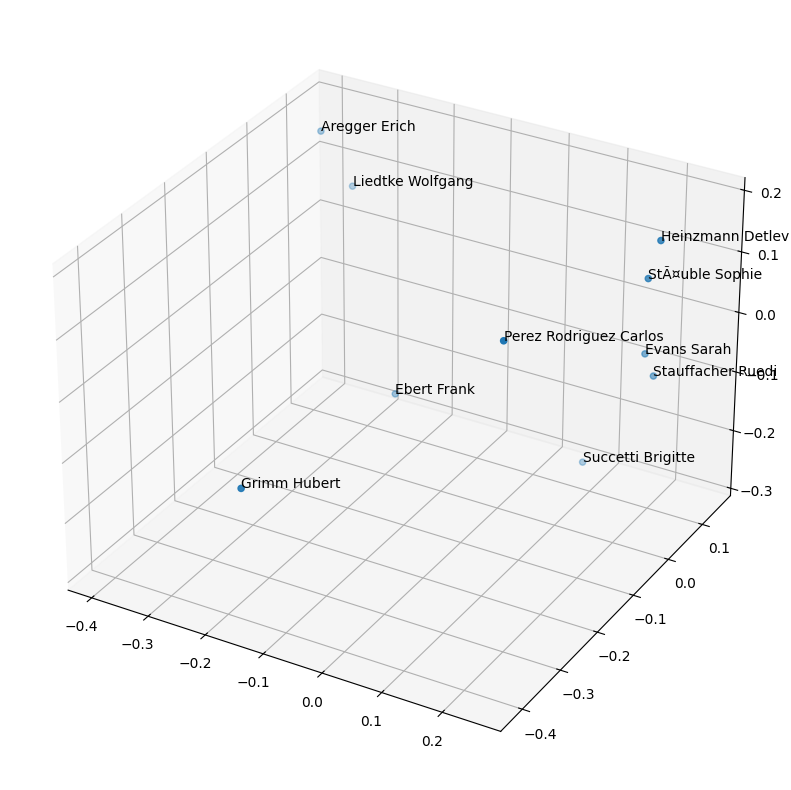

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(t[:,0],t[:,1], t[:,2])
for i, txt in enumerate(res['full_name']):
    ax.text(t[i,0], t[i,1], t[i,2], txt)
plt.show()

In [38]:
df = pd.read_csv('./data/postdefined_users_azure_data_v4.csv')
df = df[0:1400]
df = df[["full_name","quote","ada_v2"]]
df.head()

full_name  \
0          A Barik Radiah   
1         Ãbersold Heinz   
2  Aabadi Karim Alexandre   
3            Aarts Silvie   
4             Abbott Colm   

                                                                           quote  \
0                                                                    Of course .   
1  After the acquisitio Basware 's preliminary pro forma net sales for 2005 amou   
2                                       And I 'm mad at yo you 've no ambition .   
3      I want you to be everything that's you, deep at the center of your being.   
4                                          Everyone smiles in the same language.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [39]:
df["ada_v2"].shape

(1200,)

In [40]:
df.to_csv('./data/postdefined_users_azure_data_v4.csv', index=False)

In [41]:
df = pd.read_csv('./data/postdefined_users_azure_data_v5.csv')
df = df[0:1200]
df = df[["full_name","quote","ada_v2","similarities"]]
df.head()

full_name  \
0          A Barik Radiah   
1         Ãbersold Heinz   
2  Aabadi Karim Alexandre   
3            Aarts Silvie   
4             Abbott Colm   

                                                                           quote  \
0                                                                    Of course .   
1  After the acquisitio Basware 's preliminary pro forma net sales for 2005 amou   
2                                       And I 'm mad at yo you 've no ambition .   
3      I want you to be everything that's you, deep at the center of your being.   
4                                          Everyone smiles in the same language.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [42]:
df["ada_v2"].shape

(1200,)

In [43]:
df.to_csv('./data/postdefined_users_azure_data_v5.csv', index=False)